### Required imports

In [178]:
from arch import arch_model
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from pandas_datareader import DataReader
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
register_matplotlib_converters()
sns.set()
from statsmodels.tsa.stattools import adfuller

## Volatility Analysis

### 1- Model choice

Stock returns have an asymmetric shock. It is often the case. A piece of “bad news”, or a negative return, such as a drop in the stock price, reduces the value of equity relative to the fixed value of debt of that firm according to Enders (2014). The opposite effect will also be present – an increase in the stock price reduces leverage and risk. It is also often the case, that stocks move more often with the market when the market goes down than when it goes up(Yongmiao Hong et al. , The Review of Financial Studies, 2007). EGARCH model is well suited to model such asymmetric shocks. It adds a conditional component to model the asymmetry in shocks similar to the GJR-GARCH and it doesn't have a non-negative constraint on alpha and beta, making the model faster.

#### Plot of the returns

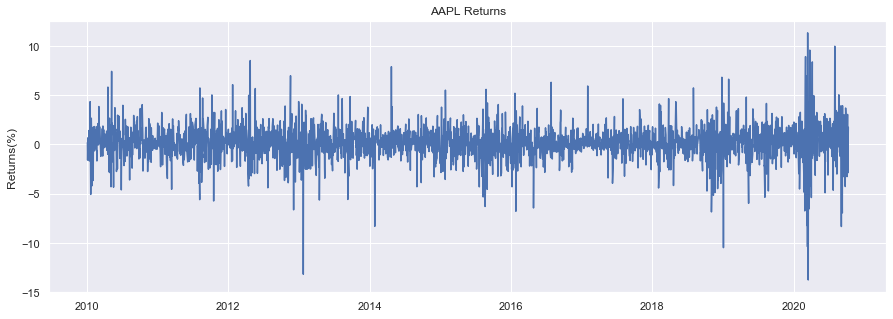

In [2]:
start_date = datetime(2010,1,1)
end_date = datetime(2020,10,9)
aapl = DataReader('AAPL',  'yahoo', start_date, end_date)
returns = pd.DataFrame(np.diff(np.log(aapl['Adj Close'].values)))
returns = 100 * returns
returns.index = aapl.index.values[1:aapl.index.values.shape[0]]
returns.columns = ['AAPL Returns']

plt.figure(figsize=(15,5));
plt.plot(returns.index,returns);
plt.ylabel('Returns(%)');
plt.title('AAPL Returns');

One way to visualize the underlying volatility of the series is to plot the absolute returns ∣y∣:

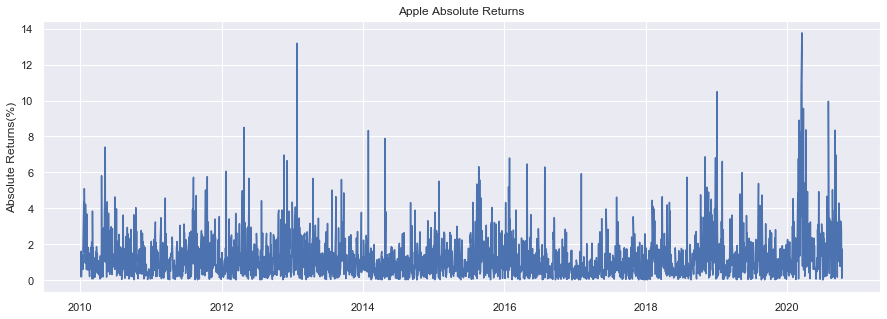

In [3]:
plt.figure(figsize=(15,5))
plt.plot(returns.index, np.abs(returns))
plt.ylabel('Absolute Returns(%)')
plt.title('Apple Absolute Returns');

#### Model specification

Iteration:     10,   Func. Count:     99,   Neg. LLF: 4760.994056625304
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4760.871301667804
            Iterations: 15
            Function evaluations: 140
            Gradient evaluations: 15
                             AR - EGARCH Model Results                              
Dep. Variable:                 AAPL Returns   R-squared:                      -0.000
Mean Model:                              AR   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -4760.87
Distribution:      Standardized Student's t   AIC:                           9533.74
Method:                  Maximum Likelihood   BIC:                           9568.96
                                              No. Observations:                 2618
Date:                      Sat, Oct 10 2020   Df Residuals:                     2612
Time:                              17

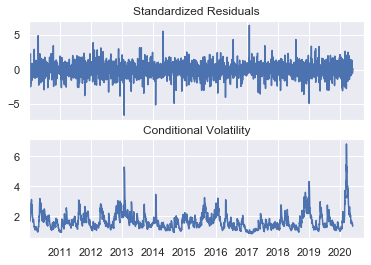

In [4]:
# Specify EGARCH model assumptions
basic_gm = arch_model(returns, p = 1, q = 1, o=1,
                      mean = 'AR', vol = 'EGARCH', dist = 't')
# Fit the model
split_date = datetime(2020,6,1)
gm_result = basic_gm.fit(update_freq = 10, last_obs=split_date)

# Display model fitting summary
print(gm_result.summary())

# Plot fitted results
gm_result.plot();
plt.show();

The coefficients are all significant at the 1% significant level as p-values for all coefficient is less than 1%. The abslolute value of the t-values are all greater than 2 as well. alpha is greater than 0.10 which indicates a spily market as clearly shown on the conditional volatility plot. beta is 0.94 which is in the high end for daily data according to Alexander(2008), meaning that the volatility has high persistency or otherwise stated, past volatility have high impact on current volatility.

#### Analysis of model residuals

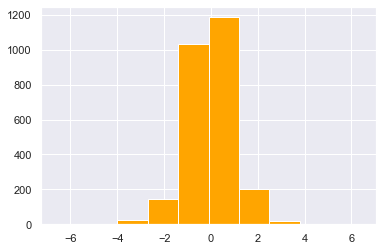

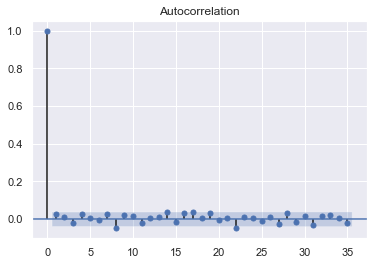

In [7]:
std_resid = gm_result.resid/gm_result.conditional_volatility
std_resid.dropna(inplace=True)
plt.hist(std_resid, facecolor = 'orange',label = 'standardized residuals');
plot_acf(std_resid, alpha=0.05);

In [8]:
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(std_resid , lags = 10, return_df=True)
# Check p-values
lb_test.lb_pvalue

1     0.191196
2     0.377703
3     0.389669
4     0.318130
5     0.447848
6     0.552290
7     0.461829
8     0.093471
9     0.106428
10    0.122627
Name: lb_pvalue, dtype: float64

The pvalue of residuals up to lag 10 is greater than 0.01, so we accept the null hypothesis of residuals that are independently distributed, i.e, there is no autocorrelation in the residuals

The model will be estimated using the first 10 years and 4 months to estimate parameters and then forecasts will be produced for the final period in the sample.

### 2- One step ahead Forecast

In [9]:
# Make 1-period ahead forecast
gm_forecast = gm_result.forecast(method = 'simulation', start=split_date)

# Print the forecast variance
print(gm_forecast.mean[-1:])

                h.1
2020-10-09  0.12645


## Multivariate Analysis
### Equilibrium CAD/USD Exchange Rate

### 1- Describe the economic theories and models used to calculate equilibrium FX

### 2- Indicate macroeconomic variables used to determine the equilibrium FX

### 3- Explain the connection between linear regression and Vector Error Correction (VEC)
Linear regression attempts to model the relationship between two or more variables by fitting a linear equation to observed data. One or more variable are considered to be independent variables, and one variable is considered to be a dependent variable.
The vector auto-regression is a system of regression which contains a set of `m` variables, each of which is expressed as a linear function of `p` lags of itself and of all of the other `m – 1` variables, plus an error term. Both linear regression and VAR use OLS to estimate paramters. When the variables of a VAR are cointegrated, we use a vector error-correction (VEC) which is a special case of VAR.

### 4- Calculate the equilibrium FX using VEC and comment all your results

In [6]:
exch=pd.read_csv('FX_RATES_DAILY_v2.csv')
Can_int=pd.read_csv('CAN5Yi.csv') #This is the 5 year Canadian bond interest rate
US_int= pd.read_csv('US5Yi.csv') #This is the 5 year Treasury bond interest rate
Can_CPI= pd.read_csv('CPI_MONTHLY_CAN.csv') #This is the actual CPI, which needs to be adjusted
US_CPI=pd.read_csv('US_CPI.csv') #This is the percent growth from previous period 

In [9]:
exch.Date= pd.to_datetime(exch.Date)

In [10]:
exch.head()

,Date,USD,CAD
0,2020-10-11,1,1.3177
1,2020-10-10,1,1.3177
2,2020-10-09,1,1.3177
3,2020-10-08,1,1.3245
4,2020-10-07,1,1.3288


In [11]:
exch.sort_values(by='Date')

,Date,USD,CAD
3653,2010-10-11,1,1.0118
3652,2010-10-12,1,1.0137
3651,2010-10-13,1,1.0029
3650,2010-10-14,1,0.9991
3649,2010-10-15,1,1.0054
...,...,...,...
4,2020-10-07,1,1.3288
3,2020-10-08,1,1.3245
2,2020-10-09,1,1.3177
1,2020-10-10,1,1.3177


In [14]:
Can_int.date=pd.to_datetime(Can_int.date)

In [15]:
Can_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 4951 non-null   datetime64[ns]
 1   CDN.AVG.1YTO3Y.AVG   4950 non-null   float64       
 2   CDN.AVG.3YTO5Y.AVG   4950 non-null   float64       
 3   CDN.AVG.5YTO10Y.AVG  4950 non-null   float64       
 4   CDN.AVG.OVER.10.AVG  4950 non-null   float64       
 5   BD.CDN.2YR.DQ.YLD    4950 non-null   float64       
 6   BD.CDN.3YR.DQ.YLD    4950 non-null   float64       
 7   BD.CDN.5YR.DQ.YLD    4950 non-null   float64       
 8   BD.CDN.7YR.DQ.YLD    4950 non-null   float64       
 9   BD.CDN.10YR.DQ.YLD   4951 non-null   float64       
 10  BD.CDN.LONG.DQ.YLD   4950 non-null   float64       
 11  BD.CDN.RRB.DQ.YLD    4950 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 464.3 KB


In [16]:
US_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    2610 non-null   object
 1   US5Yi   2610 non-null   object
dtypes: object(2)
memory usage: 40.9+ KB


In [17]:
US_int.DATE = pd.to_datetime(US_int.DATE)

In [20]:
US_CPI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    121 non-null    object 
 1   US CPI  121 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


In [21]:
US_CPI.DATE= pd.to_datetime(US_CPI.DATE)

In [22]:
US_CPI.head()

,DATE,US CPI
0,2010-07-01,0.021104
1,2010-08-01,0.138066
2,2010-09-01,0.058174
3,2010-10-01,0.124520
4,2010-11-01,0.042065


In [23]:
Can_CPI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   TERMS AND CONDITIONS  315 non-null    object
 1   Unnamed: 1            309 non-null    object
 2   Unnamed: 2            309 non-null    object
 3   Unnamed: 3            309 non-null    object
 4   Unnamed: 4            309 non-null    object
 5   Unnamed: 5            309 non-null    object
 6   Unnamed: 6            309 non-null    object
 7   Unnamed: 7            249 non-null    object
 8   Unnamed: 8            309 non-null    object
 9   Unnamed: 9            309 non-null    object
dtypes: object(10)
memory usage: 25.0+ KB


In [24]:
Can_CPI.head(30)

,TERMS AND CONDITIONS,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,https://www.bankofcanada.ca/terms/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NAME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Consumer Price Index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,DESCRIPTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"Includes CPI-trim, CPI-median, and CPI-common ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LINK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,date,Total CPI,V41690914,STATIC_TOTALCPICHANGE,CPI_TRIM,CPI_MEDIAN,CPI_COMMON,ATOM_V41693242,STATIC_CPIXFET,CPIW


In [25]:
Can_CPI= Can_CPI.iloc[9:]

In [27]:
Can_CPI.rename(columns=Can_CPI.loc[9],inplace=True)

Can_CPI.drop(labels=9,inplace=True)

Can_CPI.set_index('date',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
Can_CPI.head()

,Total CPI,V41690914,STATIC_TOTALCPICHANGE,CPI_TRIM,CPI_MEDIAN,CPI_COMMON,ATOM_V41693242,STATIC_CPIXFET,CPIW
date,,,,,,,,,
1/1/1995,86.6,86.6,0.6,1.8,1.8,1.1,NaN,2.2,1.7
2/1/1995,87,87,1.9,1.9,1.8,1.1,NaN,1.8,1.7
3/1/1995,87.2,87.2,2.1,2,1.8,1.3,NaN,2.1,1.9
4/1/1995,87.5,87.4,2.5,2.1,2,1.3,NaN,2.1,2
5/1/1995,87.7,87.7,2.9,2.3,2.1,1.4,NaN,2.5,2.2


In [39]:
US_CPI.set_index('DATE', inplace=True)

In [49]:
CPIs= pd.merge(US_CPI,Can_CPI['Total CPI'],left_index=True,right_index=True).rename(mapper= {'Total CPI':'Can CPI'},axis=1)

In [51]:
CPIs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2010-07-01 to 2020-07-01
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   US CPI   121 non-null    float64
 1   Can CPI  121 non-null    object 
dtypes: float64(1), object(1)
memory usage: 2.8+ KB


In [53]:
CPIs['Can CPI']= pd.to_numeric(CPIs['Can CPI'])

In [54]:
#This is the 5 year Treasury bond interest rate

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2010-07-01 to 2020-07-01
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   US CPI   121 non-null    float64
 1   Can CPI  121 non-null    float64
dtypes: float64(2)
memory usage: 2.8 KB


In [59]:
CPIs['Can CPI adj'] = ((CPIs['Can CPI'].shift(1)-CPIs['Can CPI'])/CPIs['Can CPI'])*100
#We convert the Canadian CPI also into %-ages 

In [56]:
CPIs['US CPI adj'] = np.log(CPIs['US CPI'].shift(1)/CPIs['US CPI'])

,US CPI,Can CPI,Can CPI adj
2010-07-01,0.021104,116.8,NaN
2010-08-01,0.138066,116.7,0.000857
2010-09-01,0.058174,116.9,-0.001712
2010-10-01,0.124520,117.4,-0.004268
2010-11-01,0.042065,117.5,-0.000851
...,...,...,...
2020-03-01,-0.217645,136.6,0.005839
2020-04-01,-0.668694,135.7,0.006610
2020-05-01,0.001950,136.1,-0.002943
2020-06-01,0.547205,137.2,-0.008050


In [113]:
CPIs

,US CPI,Can CPI,Can CPI adj
2010-07-01,0.021104,116.8,NaN
2010-08-01,0.138066,116.7,0.085690
2010-09-01,0.058174,116.9,-0.171086
2010-10-01,0.124520,117.4,-0.425894
2010-11-01,0.042065,117.5,-0.085106
...,...,...,...
2020-03-01,-0.217645,136.6,0.585652
2020-04-01,-0.668694,135.7,0.663228
2020-05-01,0.001950,136.1,-0.293902
2020-06-01,0.547205,137.2,-0.801749


In [63]:
US_int.info(), Can_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    2610 non-null   datetime64[ns]
 1   US5Yi   2610 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 40.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 4951 non-null   datetime64[ns]
 1   CDN.AVG.1YTO3Y.AVG   4950 non-null   float64       
 2   CDN.AVG.3YTO5Y.AVG   4950 non-null   float64       
 3   CDN.AVG.5YTO10Y.AVG  4950 non-null   float64       
 4   CDN.AVG.OVER.10.AVG  4950 non-null   float64       
 5   BD.CDN.2YR.DQ.YLD    4950 non-null   float64       
 6   BD.CDN.3YR.DQ.YLD    4950 non-null   float64       
 7   BD.CDN.5YR.DQ.YLD    4950 non-nul

(None, None)

In [64]:
US_int.set_index('DATE', inplace=True)

In [65]:
Can_int.set_index('date',inplace=True)

In [67]:
intS= pd.merge(US_int,Can_int['BD.CDN.5YR.DQ.YLD'],left_index=True,right_index=True)

In [70]:
exch.set_index('Date',inplace=True)

In [71]:
exch=pd.merge(exch['CAD'],intS,left_index=True,right_index=True)

In [73]:
exch.rename(mapper={'CAD':'USDCAD', 'BD.CDN.5YR.DQ.YLD':'Can5Yi'},axis=1,inplace=True)

In [74]:
exch

,USDCAD,US5Yi,Can5Yi
2020-10-08,1.3245,0.33,0.37
2020-10-07,1.3288,0.35,0.38
2020-10-06,1.3251,0.32,0.35
2020-10-05,1.3268,0.33,0.37
2020-10-02,1.3302,0.28,0.35
...,...,...,...
2010-10-18,1.0213,1.14,1.95
2010-10-15,1.0054,1.2,1.98
2010-10-14,0.9991,1.18,1.97
2010-10-13,1.0029,1.13,1.94


#######Interest rates and exchange rates are daily where as CPI is a monthly trend. 

1. We first convert the Exch rate into the daily log-returns
2. We additionally have two options:
    a. Bring down to monthly values 
    b. repopulate CPI to a daily number 
    
Here, we choose Option 2b, instead of Option 2a. 

In [114]:
df= pd.merge(exch, CPIs, left_index=True,right_index=True, how = 'outer')

In [115]:
df.head(50)

,USDCAD,US5Yi,Can5Yi,US CPI,Can CPI,Can CPI adj
2010-07-01,NaN,NaN,NaN,0.021104,116.8,NaN
2010-08-01,NaN,NaN,NaN,0.138066,116.7,0.085690
2010-09-01,NaN,NaN,NaN,0.058174,116.9,-0.171086
2010-10-01,NaN,NaN,NaN,0.124520,117.4,-0.425894
2010-10-12,1.0137,1.14,1.90,NaN,NaN,NaN
2010-10-13,1.0029,1.13,1.94,NaN,NaN,NaN
2010-10-14,0.9991,1.18,1.97,NaN,NaN,NaN
2010-10-15,1.0054,1.2,1.98,NaN,NaN,NaN
2010-10-18,1.0213,1.14,1.95,NaN,NaN,NaN
2010-10-19,1.0258,1.11,1.85,NaN,NaN,NaN


In [116]:
df.isna().sum()

USDCAD           55
US5Yi            55
Can5Yi           55
US CPI         2433
Can CPI        2433
Can CPI adj    2434
dtype: int64

In [117]:
df.shape

(2554, 6)

In [119]:
df.loc[:,'US CPI':].tail(20) #CPIs are only upto July so we expect the last part to be all NAs

,US CPI,Can CPI,Can CPI adj
2020-09-11,NaN,NaN,NaN
2020-09-14,NaN,NaN,NaN
2020-09-15,NaN,NaN,NaN
2020-09-16,NaN,NaN,NaN
2020-09-17,NaN,NaN,NaN
2020-09-18,NaN,NaN,NaN
2020-09-21,NaN,NaN,NaN
2020-09-22,NaN,NaN,NaN
2020-09-23,NaN,NaN,NaN
2020-09-24,NaN,NaN,NaN


In [99]:
df.columns.values[-3:]

array(['US CPI', 'Can CPI', 'Can CPI adj'], dtype=object)

In [123]:
df[['US CPI', 'Can CPI', 'Can CPI adj']]=df.loc[:,'US CPI':].interpolate()

In [125]:
df.tail(100)

,USDCAD,US5Yi,Can5Yi,US CPI,Can CPI,Can CPI adj
2020-05-20,1.3881,0.34,0.41,0.329103,136.760,-0.598610
2020-05-21,1.3918,0.35,0.42,0.356366,136.815,-0.624003
2020-05-22,1.4007,0.34,0.37,0.383628,136.870,-0.649395
2020-05-25,1.3988,.,0.36,0.410891,136.925,-0.674787
2020-05-26,1.3835,0.35,0.40,0.438154,136.980,-0.700180
...,...,...,...,...,...,...
2020-10-02,1.3302,0.28,0.35,0.505824,137.200,0.000000
2020-10-05,1.3268,0.33,0.37,0.505824,137.200,0.000000
2020-10-06,1.3251,0.32,0.35,0.505824,137.200,0.000000
2020-10-07,1.3288,0.35,0.38,0.505824,137.200,0.000000


In [127]:
df.isna().sum()

USDCAD         55
US5Yi          55
Can5Yi         55
US CPI          0
Can CPI         0
Can CPI adj     1
dtype: int64

In [130]:
df= df.dropna().loc[:'2020-06-30']

In [131]:
df #The data is ready

,USDCAD,US5Yi,Can5Yi,US CPI,Can CPI,Can CPI adj
2010-10-12,1.0137,1.14,1.90,0.119023,117.406667,-0.403175
2010-10-13,1.0029,1.13,1.94,0.113526,117.413333,-0.380456
2010-10-14,0.9991,1.18,1.97,0.108029,117.420000,-0.357737
2010-10-15,1.0054,1.2,1.98,0.102532,117.426667,-0.335018
2010-10-18,1.0213,1.14,1.95,0.097035,117.433333,-0.312298
...,...,...,...,...,...,...
2020-06-24,1.3591,0.33,0.38,0.515229,137.200000,-0.182216
2020-06-25,1.3645,0.32,0.37,0.513348,137.200000,-0.145773
2020-06-26,1.3661,0.3,0.36,0.511467,137.200000,-0.109329
2020-06-29,1.3656,0.28,0.36,0.509586,137.200000,-0.072886


In [132]:
#First we apply log on the exchange rates

df['USDCAD_returns']= np.log(df.USDCAD.shift(1)/df.USDCAD)

In [135]:
df.dropna(inplace=True)

In [157]:
clean_df = df.drop(labels=['Can CPI','USDCAD'],axis=1)

In [158]:
clean_df

,US5Yi,Can5Yi,US CPI,Can CPI adj,USDCAD_returns
2010-10-13,1.13,1.94,0.113526,-0.380456,0.010711
2010-10-14,1.18,1.97,0.108029,-0.357737,0.003796
2010-10-15,1.2,1.98,0.102532,-0.335018,-0.006286
2010-10-18,1.14,1.95,0.097035,-0.312298,-0.015691
2010-10-19,1.11,1.85,0.091538,-0.289579,-0.004396
...,...,...,...,...,...
2020-06-24,0.33,0.38,0.515229,-0.182216,-0.007385
2020-06-25,0.32,0.37,0.513348,-0.145773,-0.003965
2020-06-26,0.3,0.36,0.511467,-0.109329,-0.001172
2020-06-29,0.28,0.36,0.509586,-0.072886,0.000366


##### Next steps

Now we have 5 series and we believe there is a possibility of Co integration. 
Here are the steps: 

1. Check each series for stationarity
2. Check each series difference of 1 for stationarity
3. Hence proving they are I(1)
4. Consider each series to be a possibility

In [159]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2429 entries, 2010-10-13 to 2020-06-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   US5Yi           2429 non-null   object 
 1   Can5Yi          2429 non-null   float64
 2   US CPI          2429 non-null   float64
 3   Can CPI adj     2429 non-null   float64
 4   USDCAD_returns  2429 non-null   float64
dtypes: float64(4), object(1)
memory usage: 193.9+ KB


In [160]:
clean_df.US5Yi.str.replace(r'\A\..*\Z',lambda x: np.nan).isna().sum()

42

In [154]:
clean_df[clean_df.US5Yi=='.']

,US5Yi,Can5Yi,US CPI,Can CPI adj,USDCAD_returns
2010-11-25,.,2.45,0.147124,-0.016211,0.006218
2010-12-24,.,2.44,0.418327,-0.206161,0.005428
2011-01-17,.,2.56,0.484329,-0.254361,0.009277
2011-05-30,.,2.32,-0.054595,0.546768,0.000410
2011-07-04,.,2.32,0.097517,-0.170605,0.005610
2011-11-24,.,1.34,-0.208010,0.424011,-0.001054
2012-01-16,.,1.28,0.440146,-0.413473,-0.001078
2012-05-28,.,1.32,-0.141314,0.351314,0.003022
2012-07-04,.,1.23,-0.097570,0.052431,0.003153
2012-10-30,.,1.37,-0.434271,0.208852,-0.000100


In [161]:
clean_df.US5Yi=clean_df.US5Yi.str.replace(r'\A\..*\Z',lambda x: np.nan)

In [188]:
clean_df.isna().sum()

US5Yi             42
Can5Yi             0
US CPI             0
Can CPI adj        0
USDCAD_returns     0
dtype: int64

In [166]:
clean_df.US5Yi=pd.to_numeric(clean_df.US5Yi)

In [190]:
clean_df.dropna(inplace=True)

In [191]:
clean_df

,US5Yi,Can5Yi,US CPI,Can CPI adj,USDCAD_returns
2010-10-13,1.13,1.94,0.113526,-0.380456,0.010711
2010-10-14,1.18,1.97,0.108029,-0.357737,0.003796
2010-10-15,1.20,1.98,0.102532,-0.335018,-0.006286
2010-10-18,1.14,1.95,0.097035,-0.312298,-0.015691
2010-10-19,1.11,1.85,0.091538,-0.289579,-0.004396
...,...,...,...,...,...
2020-06-24,0.33,0.38,0.515229,-0.182216,-0.007385
2020-06-25,0.32,0.37,0.513348,-0.145773,-0.003965
2020-06-26,0.30,0.36,0.511467,-0.109329,-0.001172
2020-06-29,0.28,0.36,0.509586,-0.072886,0.000366


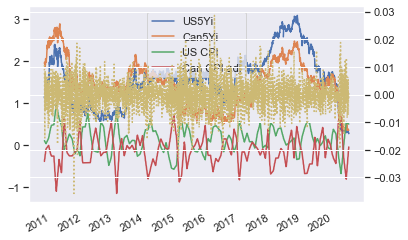

In [177]:
clean_df.loc[:,:'Can CPI adj'].plot()
clean_df.USDCAD_returns.plot(secondary_y=True, style='y:')
plt.show()

##
They all look pretty stationary

In [180]:
exch_stat=adfuller(clean_df.USDCAD_returns)

In [182]:
exch_stat

(-49.003159599789235,
 0.0,
 0,
 2428,
 {'1%': -3.4330461396142007,
  '5%': -2.8627311246351157,
  '10%': -2.5674040843983836},
 -18579.04989476632)

In [183]:
# t value is less than the significant values, and hence is pretty stationary in this case

In [192]:
adfuller(clean_df.US5Yi) #This does not look stationary

(-1.1349076690016937,
 0.7009523386104732,
 7,
 2379,
 {'1%': -3.4331017317952215,
  '5%': -2.8627556733140143,
  '10%': -2.567417154581006},
 -7877.315079737036)

In [193]:
adfuller(clean_df.Can5Yi) #Nor does this

(-1.4646884951644634,
 0.5509015519457117,
 0,
 2386,
 {'1%': -3.4330936501081823,
  '5%': -2.8627521045897844,
  '10%': -2.5674152545197644},
 -8269.6861596124)

##

Now we attempt the cointegration itself

In [195]:
from  statsmodels.tsa.vector_ar import vecm

In [199]:
ans =vecm.coint_johansen(clean_df,0,1)

In [200]:
type(ans)

statsmodels.tsa.vector_ar.vecm.JohansenTestResult

In [202]:
print(dir(ans))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cvm', '_cvt', '_eig', '_evec', '_ind', '_lr1', '_lr2', '_meth', '_r0t', '_rkt', 'cvm', 'cvt', 'eig', 'evec', 'ind', 'lr1', 'lr2', 'max_eig_stat', 'max_eig_stat_crit_vals', 'meth', 'r0t', 'rkt', 'trace_stat', 'trace_stat_crit_vals']


In [204]:
ans.lr1

array([1422.68795217,  210.72676135,   69.04796194,    6.68087659,
          1.94487185])

In [205]:
ans.lr2

array([1211.96119082,  141.67879941,   62.36708535,    4.73600474,
          1.94487185])

In [206]:
ans.cvm

array([[31.2379, 33.8777, 39.3693],
       [25.1236, 27.5858, 32.7172],
       [18.8928, 21.1314, 25.865 ],
       [12.2971, 14.2639, 18.52  ],
       [ 2.7055,  3.8415,  6.6349]])

In [207]:
ans.trace_stat

array([1422.68795217,  210.72676135,   69.04796194,    6.68087659,
          1.94487185])

###
I don't know how to interpret this unfortunately, Yet

In [210]:
clean_df.columns

Index(['US5Yi', 'Can5Yi', 'US CPI', 'Can CPI adj', 'USDCAD_returns'], dtype='object')

In [209]:
ans.trace_stat_crit_vals

array([[65.8202, 69.8189, 77.8202],
       [44.4929, 47.8545, 54.6815],
       [27.0669, 29.7961, 35.4628],
       [13.4294, 15.4943, 19.9349],
       [ 2.7055,  3.8415,  6.6349]])